In [6]:
import os
import cv2

import matplotlib.pyplot as plt
import numpy as np
import skimage.transform
import skimage.color
import tensorflow as tf
from tensorflow.python.keras import Model

from chroma_instance.config.FirstTest import FirstTestConfig
from chroma_instance.data.generator_single_file import DataSingleFile
from chroma_instance.model.fusion import FusionModel

tf.enable_eager_execution()

In [2]:
config = FirstTestConfig('final6', ROOT_DIR='../../../')
config.BATCH_SIZE = 1
config.PRETRAINED = 'fusion_final.h5'

save_path = os.path.join(config.MODEL_DIR, config.PRETRAINED)
fusion_model = FusionModel(config)
fusion_model.combined.load_weights(save_path)

In [22]:
# config.TEST_DIR = "imagenet_ctest"
# test_data = DataSingleFile(config.TEST_DIR, "ILSVRC2012_val_00033944.JPEG", config)
config.TEST_DIR = "coco_test_2017"
test_data = DataSingleFile(config.TEST_DIR, "000000123057.jpg", config)
batch = test_data.generate_batch()
batch_X = batch.resized_images.l
batch_Y = batch.resized_images.ab

print(fusion_model.combined.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 1, 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 28, 28, 512, 47528866    input_3[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 4, 2)]       0                                            
____________________________________________________________________________________________

In [23]:
fg_model_3, fg_conv2d_11, fg_conv2d_13, fg_conv2d_15, fg_conv2d_17 = fusion_model.foreground_generator.predict(
    batch.instances.l)

fusion_img_pred_ab, _ = fusion_model.fusion_generator.predict(
    [batch.resized_images.l, fg_model_3, fg_conv2d_11, fg_conv2d_13, fg_conv2d_15, fg_conv2d_17,
     batch.instances.bbox, batch.instances.mask])

Total instances: 4


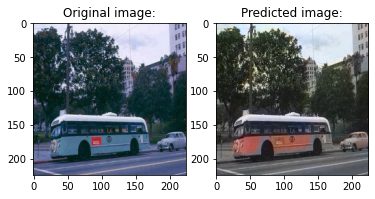

In [24]:
print(f"Total instances: {batch.object_n[0]}")

plt.subplot(1, 2, 1)
plt.title("Original image:")
original_rgb = batch.images.full[:, :, :, [2, 1, 0]][0]
plt.imshow(skimage.transform.resize(original_rgb, (224, 224)))
plt.subplot(1, 2, 2)
plt.title("Predicted image:")
lab = tf.concat((batch.resized_images.l[0], fusion_img_pred_ab[0]), -1)
rgb = cv2.cvtColor(np.clip(lab*255, 0, 255).astype(np.uint8), cv2.COLOR_Lab2RGB)
plt.imshow(rgb)
plt.show()

fg_conv2d_17 has shape: (1, 112, 112, 2, 2)


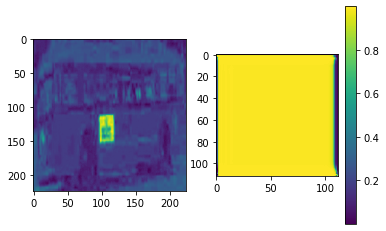

In [25]:
plt.subplot(1, 2, 1)
plt.imshow(batch.instances.ab[0, :, :, 0, 0])

plt.subplot(1, 2, 2)
print(f"fg_conv2d_17 has shape: {fg_conv2d_17.shape}")
slice = fg_conv2d_17[0, :, :, 1, 0]
plt.imshow(slice)
plt.colorbar()
plt.show()